In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import DiscriminatorExperiment, DiscriminatorAnalysis


In [3]:
class DiscriminatorBackend(BaseBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self):
        """
        Initialize the discriminator backend
        """
        configuration = QasmBackendConfiguration(
            backend_name="discriminator_simulator",
            backend_version="0",
            n_qubits=int(1e6),
            basis_gates=["x", "measure"],
            gates=[],
            local=True,
            simulator=True,
            conditional=False,
            open_pulse=False,
            memory=False,
            max_shots=int(1e6),
            coupling_map=None,
        )

        super().__init__(configuration)

    def sample_gaussian(self, centroid=np.array([0,0]), cov=np.array([[0.1,0],[0,0.1]]), size=1):
        """
        Draws random samples from a gaussian distribution.
        """
        return np.random.multivariate_normal(centroid, cov, size)

    # pylint: disable = arguments-differ
    def run(self, qobj):
        """
        Run the discriminator backend
        """

        shots = qobj.config.shots

        result = {
            "backend_name": "Discriminator backend",
            "backend_version": "0",
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        for circ in qobj.experiments:
            nqubits = circ.config.n_qubits
            centroids = np.zeros([nqubits, 2])
            counts = dict()
            memory = np.zeros([shots, circ.config.memory_slots, 2])

            for i in range(shots):
                clbits = np.zeros(circ.config.memory_slots, dtype=int)
                meas_res = 0
                for op in circ.instructions:
                    qubit = op.qubits[0]
                    if op.name == "x":
                        meas_res=1
                    elif op.name == "measure":
                        # centroid is either (0,0) for |0> or (1,1) for |1>
                        memory[i, op.memory[0]] = self.sample_gaussian(centroid=np.array([meas_res, meas_res]))
                        clbits[op.memory[0]] = meas_res

                clstr = ""
                for clbit in clbits[::-1]:
                    clstr = clstr + str(clbit)

                if clstr in counts:
                    counts[clstr] += 1
                else:
                    counts[clstr] = 1

            result["results"].append(
                {
                    "shots": shots,
                    "success": True,
                    "header": {"metadata": circ.header.metadata},
                    "data": {"counts": counts, "memory": memory},
                }
            )

        return Result.from_dict(result)

---------------------------------------------------
Experiment: DiscriminatorExperiment
Experiment ID: 0e2fb8a3-5c39-4cf0-b8bb-728e298cf602
Status: COMPLETE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: [LinearDiscriminantAnalysis(), LinearDiscriminantAnalysis()]
- coef: [array([[10.27659574, 12.67167033]]), array([[ 8.17841177, 11.5788458 ]])]
- intercept: [array([-11.62283642]), array([-10.38375439])]
- score: [0.99, 0.99]
- plt: [<AxesSubplot:xlabel='I data', ylabel='Q data'>
 <AxesSubplot:xlabel='I data', ylabel='Q data'>]


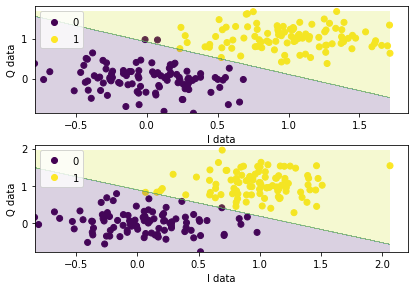

In [72]:
backend = DiscriminatorBackend()
exp = DiscriminatorExperiment(2)
res = exp.run(
    backend,
    shots=100,
    meas_level=1,
    meas_return='single',
    discriminator_type="LDA"
)
print(res)

---------------------------------------------------
Experiment: DiscriminatorExperiment
Experiment ID: 61952dfa-2892-4f17-ad44-d3b97b8bc953
Status: COMPLETE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: [QuadraticDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
- rotations: [[array([[ 0.98443542, -0.1757467 ],
       [-0.1757467 , -0.98443542]]), array([[-0.6609922 ,  0.75039277],
       [-0.75039277, -0.6609922 ]])], [array([[-0.97439568,  0.22484006],
       [-0.22484006, -0.97439568]]), array([[-0.94716613, -0.32074339],
       [-0.32074339,  0.94716613]])]]
- score: [0.985, 0.99]
- plt: [<AxesSubplot:xlabel='I data', ylabel='Q data'>
 <AxesSubplot:xlabel='I data', ylabel='Q data'>]


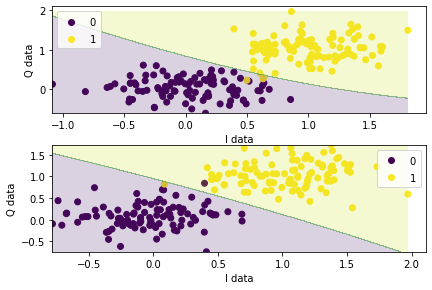

In [73]:
backend = DiscriminatorBackend()
exp = DiscriminatorExperiment(2)
res = exp.run(
    backend,
    shots=100,
    meas_level=1,
    meas_return='single',
    discriminator_type="QDA"
)
print(res)